# Table of Contents
* [Loading data](#Loading-data)
* [derived columns](#derived-columns)
	* [creating target_labels](#creating-target_labels)
* [Venue/Journal info](#Venue/Journal-info)
* [missing values](#missing-values)
	* [dropping meaningless columns](#dropping-meaningless-columns)
* [Exploring features](#Exploring-features)


In [141]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import json
import glob

In [196]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
plt.rcParams['figure.figsize'] = (16.0, 10.0)
import seaborn as sns
sns.set()

In [257]:
import nltk
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [259]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier,RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, VarianceThreshold 
from sklearn.cross_validation import ShuffleSplit
import sklearn.metrics as skmet

In [242]:
from sklearn.naive_bayes import MultinomialNB

# Loading data

In [13]:
sample_data_dir = './data/corpus_1_pct_sample/'
test_file = sample_data_dir + 'part-00000'

In [18]:
corpus_sample_raw_df = pd.DataFrame()

In [20]:
for file in glob.glob(sample_data_dir + '*'):
    running_idx = 0
    with open(file, 'r') as f:
        json_lines = f.readlines()
        record_by_index = {running_idx + idx: json.loads(record) for idx, record in enumerate(json_lines)}
        running_idx += len(json_lines)
        if corpus_sample_raw_df.empty:
            corpus_sample_raw_df = pd.DataFrame.from_dict(record_by_index, orient='index')
        else:
            corpus_sample_raw_df = corpus_sample_raw_df.append(pd.DataFrame.from_dict(record_by_index, orient='index'))

In [22]:
corpus_sample_raw_df.shape

(49621, 30)

In [24]:
sorted(list(corpus_sample_raw_df.columns))

['authors',
 'bodyText',
 'citationContexts',
 'citedBy',
 'citedByYearHistogram',
 'classification',
 'clusterInfo',
 'dataSetNames',
 'earliestAcquisitionDate',
 'estimatedCitationAcceleration',
 'estimatedCitationVelocity',
 'followOn',
 'id',
 'indexInclusionReason',
 'journal',
 'keyCitedByYearHistogram',
 'keyPhrases',
 'numCitedBy',
 'numCitedByEstimate',
 'numCiting',
 'numKeyCitations',
 'numKeyReferences',
 'paperAbstract',
 'presentationIds',
 'socialLinks',
 'sourceInfo',
 'title',
 'venue',
 'viewablePdfId',
 'year']

# derived columns

In [205]:
corpus_sample_raw_df['author_len'] = corpus_sample_raw_df['authors'].apply(lambda x: len(x))

## creating target_labels

In [161]:
def assign_fos(venue):
    NS_venues = ['The Journal of neuroscience : the official journal of the Society for Neuroscience', 'NEUROIMAGE', 'Frontiers in Neuroscience']
    CS_venues = ['HICSS', 'CVPR', 'SIGGRAPH']
    if venue in NS_venues:
        return 'NS'
    elif venue in CS_venues:
        return 'CS'
    else:
        return np.NaN

In [206]:
corpus_sample_raw_df['FOS'] = corpus_sample_raw_df['venue'].apply(assign_fos)

In [207]:
corpus_sample_raw_df['FOS'].value_counts()

CS    291
NS    157
Name: FOS, dtype: int64

# Venue/Journal info

In [134]:
len(pd.unique(corpus_sample_raw_df['venue']))

6259

In [142]:
corpus_sample_raw_df['venue'].value_counts()[:15]

                             5156
PloS one                     1387
ArXiv                         647
ICASSP                        318
Scientific reports            207
ICIP                          202
ICC                           202
IEICET                        183
ISCAS                         181
INTERSPEECH                   178
ICRA                          178
British journal of cancer     173
GLOBECOM                      163
AMC                           159
IGARSS                        152
Name: venue, dtype: int64

In [53]:
vj_df = corpus_sample_raw_df[['venue', 'journal']].dropna()

In [59]:
vj_df_hasname = vj_df[vj_df['journal'].apply(lambda x: 'name'  in x.keys())]

In [66]:
%%capture
vj_df_hasname['journal_name'] = vj_df_hasname['journal'].apply(lambda x: x['name'])

In [81]:
vj_df_name_nn = vj_df_hasname[vj_df_hasname['journal_name'] != ''][vj_df_hasname['venue'] != ''][['venue', 'journal_name']]

In [109]:
venue_lookup = defaultdict(list)
for venue, journal_df in vj_df_name_nn.groupby('venue'):
    venue_lookup[venue].append(pd.unique(journal_df['journal_name']).tolist())

In [105]:
pd.Series(venue_lookup).to_csv('journal_lookup.csv')

# missing values

In [33]:
(corpus_sample_raw_df['venue'] == "").sum()

5156

In [106]:
corpus_sample_raw_df.isnull().sum()/corpus_sample_raw_df.shape[0]

authors                          0.000000
bodyText                         0.000000
citationContexts                 0.000000
citedBy                          0.000000
citedByYearHistogram             0.000000
classification                   0.000000
clusterInfo                      0.000000
dataSetNames                     0.000000
earliestAcquisitionDate          0.475928
estimatedCitationAcceleration    0.000000
estimatedCitationVelocity        0.000000
followOn                         0.000000
id                               0.000000
indexInclusionReason             0.000000
journal                          0.106527
keyCitedByYearHistogram          0.000000
keyPhrases                       0.000000
numCitedBy                       0.000000
numCitedByEstimate               0.000000
numCiting                        0.000000
numKeyCitations                  0.000000
numKeyReferences                 0.000000
paperAbstract                    0.000000
presentationIds                  0

## dropping bad columns

In [226]:
all_cols = list(corpus_sample_raw_df.columns)
keep_cols = ['bodyText', 'paperAbstract', 'title']
synth_cols = ['author_len', 'FOS']

In [209]:
corpus_sample_proc_df = corpus_sample_raw_df.copy()
for col in all_cols:
    if col not in keep_cols + synth_cols:    
        corpus_sample_proc_df.drop(col, 1, inplace=True)

In [210]:
corpus_sample_labeled_df = corpus_sample_proc_df.dropna()
corpus_sample_labeled_df.shape

(448, 5)

In [212]:
labeled_df.head(2)

,bodyText,paperAbstract,title,FOS,author_len,target,title_len
138,0,Does breastfeeding alter early brain developme...,Nutritional influences on early white matter d...,NS,5,False,91
198,"Introduction\n\nRandom variables are "" concord...","In brain-imaging research, we are often intere...",Quantifying inter-subject agreement in brain-i...,NS,7,False,61


In [ ]:
labeled_df['title_len'] = labeled_df['title'].apply(lambda x: len(x))

# Exploring features

In [247]:
labeled_df = corpus_sample_labeled_df.replace('', '0')
labeled_df['target'] = labeled_df['FOS'] == 'CS'
# _ = labeled_df['author_len'].hist(log = False, bins = 30)

In [248]:
labeled_df['title_len'] = labeled_df['title'].apply(lambda x: np.log(len(x)))
labeled_df['abs_len'] = labeled_df['paperAbstract'].apply(lambda x: np.log(len(x)))
labeled_df['body_len'] = labeled_df['bodyText'].apply(lambda x: np.log(len(x)))
labeled_df['all_text'] = labeled_df['title'].str.cat(labeled_df['paperAbstract'], ' ').str.cat(labeled_df['bodyText'], ' ')
for col in keep_cols:
    labeled_df.drop(col, 1, inplace=True)

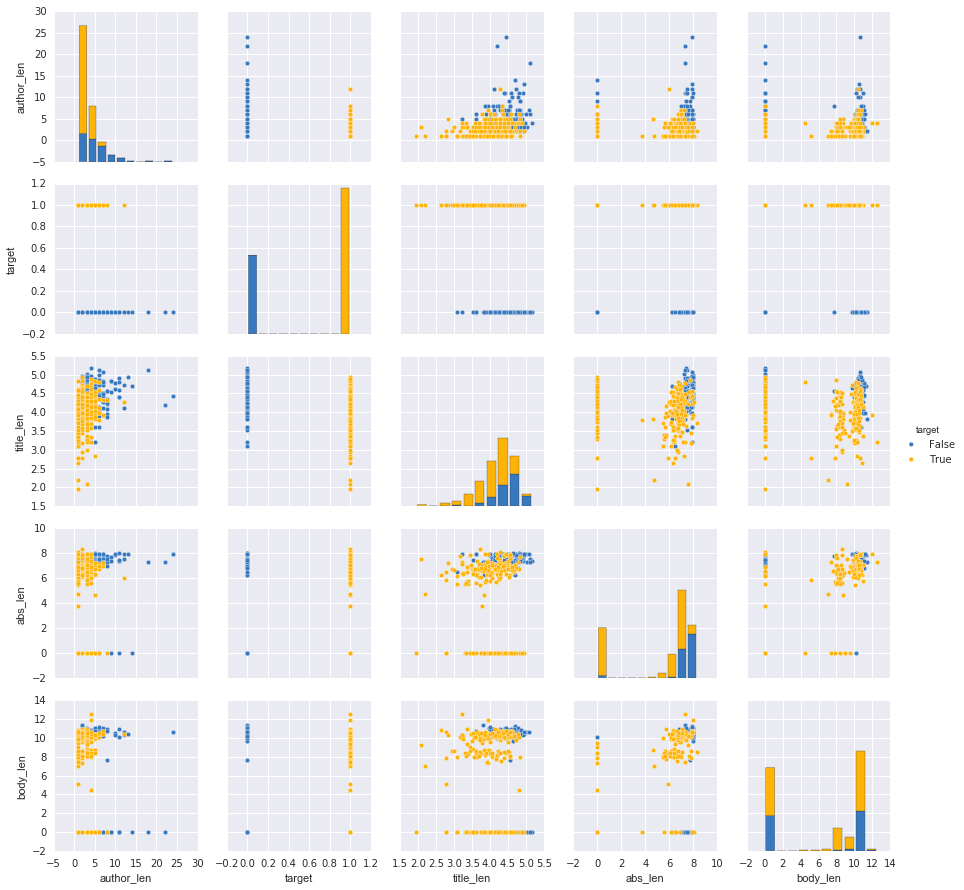

In [240]:
colors = ["windows blue", "amber"]
my_pal = sns.xkcd_palette(colors)
_ = sns.pairplot(labeled_df, hue = 'target', palette = my_pal)

# Baseline Model

In [250]:
stop_words = (stopwords.words() + list(string.punctuation) + ["''", "``", "--"])

def clean_text(s, stop_words, stemmer):
    tokens = word_tokenize(s.replace('\n', ''), language='english')
    stop_removed = [word for word in tokens if word not in stop_words]
    stem = stemmer(language='english')
    stemmed_words = " ".join([stem.stem(word) for word in stop_removed])
    return stemmed_words

def clean_text(s, stop_words):
    tokens = word_tokenize(s.replace('\n', ''), language='english')
    stop_removed = [word for word in tokens if word not in stop_words]
    return stemmed_words

In [249]:
labeled_df.head(2)

,FOS,author_len,target,title_len,abs_len,body_len,all_text
138,NS,5,False,4.510860,7.281386,0.000000,Nutritional influences on early white matter d...
198,NS,7,False,4.110874,7.017506,10.885828,Quantifying inter-subject agreement in brain-i...


In [254]:
train_df = labeled_df['all_text']
labels = labeled_df['target']
# cleaned_train = train_df.apply(lambda x : clean_text(x, stop_words, SnowballStemmer))
cleaned_train = train_df

In [260]:
mnbc = MultinomialNB()
X_train, X_test, y_train, y_test =train_test_split(cleaned_train, labels, test_size = 0.30)
tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X_train)
tfs = tfidf.transform(X_train)
mnbc.fit(tfs, y_train)
test_tfs  = tfidf.transform(X_test)
print(skmet.accuracy_score(mnbc.predict(test_tfs), y_test))

0.933333333333


# End 

In [ ]:
# corpus_sample_raw_df.replace(['',[]], np.NaN)